<a href="https://colab.research.google.com/github/maslory21/Testing/blob/main/homeworks/hw_language_modeling_01_simple/hw_language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [113]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-12-03 12:00:45--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2024-12-03 12:00:45 (8.73 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [114]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [84]:
# do not change the code in the block below
# __________start of block__________
batch_size = 3
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [65]:
next(generate_chunk())

array([[83, 13,  0, 52, 49, 50, 62, 73,  1, 46, 45, 61, 53, 58,  1, 62,
        53, 51, 53, 47, 45, 56,  1, 59, 49, 53, 58,  7,  0,  0,  0,  0,
        40, 38, 26, 26, 26,  0,  0, 52, 49, 50, 62, 73,  1, 62,  1, 58,
        53, 57,  1, 59, 46, 50, 49, 72, 47, 45, 56,  1, 52, 53, 57, 59,
        75,  0, 60, 59, 55, 59, 54, 58, 72, 54,  1, 56, 50, 58, 62, 55,
        53, 54,  5,  1, 58, 45, 69,  1, 62, 59, 62, 50, 49,  7,  0, 62,
        75, 49, 45,  1, 60],
       [83, 59, 51, 45, 56, 64, 54, 63, 50,  5,  1, 52, 45,  1, 57, 58,
        59, 75,  7,  0, 47, 59, 63,  1, 74, 63, 59,  1, 46, 45, 61, 62,
        55, 53, 54,  1, 55, 45, 46, 53, 58, 50, 63, 13,  0, 52, 49, 50,
        62, 73,  1, 60, 59, 68, 53, 47, 45, 56,  1, 59, 58,  5,  1, 55,
        59, 65, 50, 54,  1, 55, 64, 69, 45, 56,  5,  0, 60, 61, 53, 55,
        45, 52, 68, 53, 55, 45,  1, 49, 59, 55, 56, 45, 49, 72,  1, 62,
        56, 64, 69, 45, 56],
       [83,  0, 53,  1, 55, 58, 53, 51, 55, 64,  1, 60, 59, 64, 63, 61,
      

Далее вам предстоит написать код для обучения модели и генерации текста.

In [115]:
import random
chunk_len = 200
file_len = len(text)

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk())

тию она.



xxxii

привычка усладила горе,
не отразимое ничем;
открытие большое вскоре
ее утешило совсем:
она меж делом и досугом
открыла тайну, как супругом
самодержавно управлять,
и всё тогда пошло н


In [96]:
solo_chunk = random_chunk()
print(solo_chunk)
print(type(solo_chunk), len(solo_chunk))

print(''.join([idx_to_token[x] for x in solo_chunk]))

[56 73 58 72  5  1 63 45 55  1 63 59 68 58 72  5  0 63 45 55  1 58 50 60
 61 53 62 63 64 60 58 72  1 49 56 76  1 57 64 51 68 53 58  5  0 68 63 59
  1 47 53 49  1 53 66  1 64 51  1 61 59 51 49 45 50 63  1 62 60 56 53 58
  7  0  0  0  0 40 28 26 26 26  0  0 53  1 47 72  5  1 55 61 45 62 59 63
 55 53  1 57]
<class 'numpy.ndarray'> 100
льны, так точны,
так неприступны для мужчин,
что вид их уж рождает сплин.



xliii

и вы, красотки м


In [137]:

import string
import random
import re
import torch
import torch.nn as nn
import time
import math


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

In [138]:
def char_tensor(string):
    tensor = torch.zeros(len(string), dtype=torch.long)
    for c in range(len(string)):
        tensor[c] = token_to_idx[string[c]]
    return tensor

print(char_tensor('abcdefx'))


tensor([18, 19, 20, 21, 22, 23, 40])


In [139]:
def random_training_set():
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [140]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(num_tokens, hidden_size, num_tokens, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [146]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]

    for _ in range(predict_len):
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        output_dist = output_dist / output_dist.sum()  # Normalize
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = idx_to_token[top_i.item()]
        predicted += predicted_char
        inp = char_tensor(predicted_char)[0]

    return predicted

In [147]:
import time
import math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [148]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len


In [149]:
start = time.time()
all_losses = []
loss_avg = 0

n_epochs = 2000

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('a', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 13s (100 5%) 2.5620]
ar7vdeztootk<b8wщу, серостье!




ii

одвее до всез ска соброй вия, ладене, тобной,
усезмели страчило 

 27s (200 10%) 2.4412]
apкрудь онят,
не но ( селя.
оне любрастоту, наше рачисть,
с он грудь нечнестветец боеденневою потой
к 

 41s (300 15%) 2.1617]
a-xlii

до мне сет полно же сло дый свый,
не пето бетрет редава, лета, нет души не?»! – клаты
блажных 

 54s (400 20%) 2.1035]
astta-es)» – – в том немал;
пожедной в томной не не пладной
и моей свой с очно летой,
лубои, не и лы  

 8s (500 25%) 2.1199]
adal., пребинит сладцой;
заменин о клойного в знык?
соумали стрим с ревствоц.
он посторуский моли нег 

 22s (600 30%) 1.9984]
aba[z<tos

словенный ведном вприсамаланна,
гласкою сада…



xxix

как зни тепет, снуя, сладалиной рап 

 36s (700 35%) 2.3118]
a
омном стенье сержалось.




xxxiii

и сторое лет!



xiii

он мой глятьюсь порок.
хазал!» ониказать 

 50s (800 40%) 2.2417]
a
когда плятил к подени скала
на жде вольно он в ной простал я ние всердит,
устал он в сме

In [151]:
print(all_losses)

[2.3911907653808595, 2.370727844238281, 2.3391116333007815, 2.3980491333007814, 2.3365175018310547, 2.2979264984130863, 2.4283204040527346, 2.373179794311523, 2.3214608459472656, 2.353507858276367, 2.3010834960937503, 2.2465030975341795, 2.293969985961914, 2.266032913208008, 2.3052601318359374, 2.3078264770507815, 2.3373026580810548, 2.253982604980469, 2.2769207153320314, 2.212102310180664, 2.2082490081787105, 2.2236278228759767, 2.1896818847656254, 2.2148701019287107, 2.233379470825195, 2.6578452758789064, 2.2650634002685543, 2.187889221191406, 2.276487426757812, 2.2364360809326174, 2.163976089477539, 2.153363464355469, 2.157206329345703, 2.276905700683593, 2.222420913696289, 2.2705355987548828, 2.1837689666748044, 2.2094019165039063, 2.1236427612304687, 2.145726058959961, 2.168919616699219, 2.199687088012695, 2.2082254943847657, 2.1354349670410153, 2.179661880493164, 2.2325548248291014, 2.1068873596191406, 2.264266403198242, 2.1578556671142577, 2.2194478302001954, 2.2210864868164064,

In [20]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any

    # your code here

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

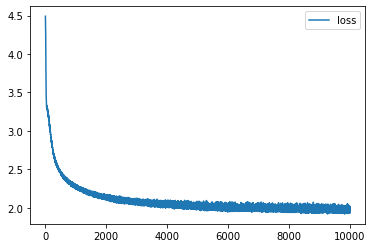

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:
generated_phrases = # your code here

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [ ]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

На этом задание завершено. Поздравляем!